<a href="https://colab.research.google.com/github/Mrutyunjay01/Tensorflow_in_practice/blob/master/Sequence%2C%20Time%20Series%20Analysis/ForecastingTimeSeriesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x

except Exception:
  pass

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


Set up the time series with seasonality and noise.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


In [0]:
def plot_series(time, series, format='-', start=0, end=None):

  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Series')
  plt.grid(True)

In [0]:
# function to set up a trend
def trend(time, slope=0):
  return time * slope

In [0]:
# define seasonality pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1./np.exp(3 * season_time))

In [0]:
def seasonality(time, period, amplitude=1, phase=0):
  """ Repeats the same pattern in each period."""

  season_time = ((time+phase)%period)/period
  return amplitude * seasonal_pattern(season_time)

In [0]:
# add some noise 
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
# set up the parameters
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
series = trend(time, slope=0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [0]:
# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# add some noies
series += noise(time, noise_level=noise_level, seed=42)

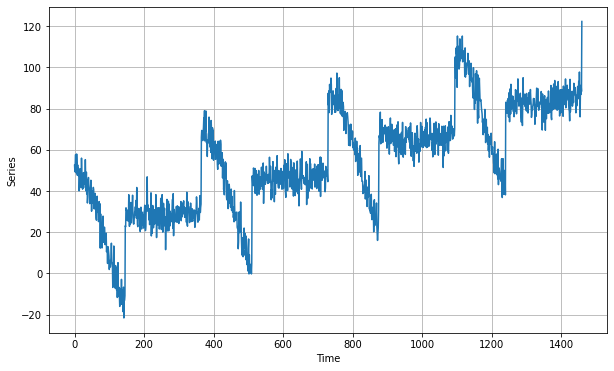

In [11]:
# visualize the seris that you just created
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
splitTime = int(len(time) * 0.8)
time_train = time[:splitTime]
x_train = series[:splitTime]

time_valid = time[splitTime:]
x_valid = series[splitTime:]

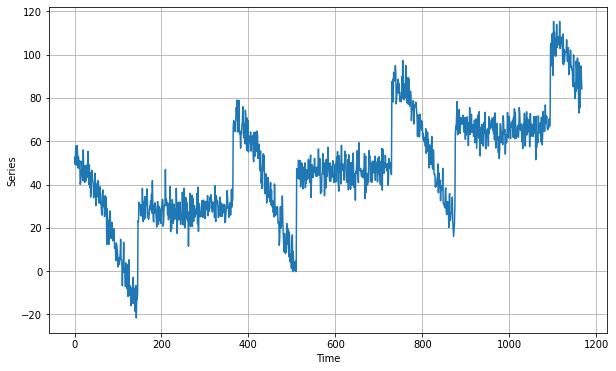

In [13]:
# c'mon, just check once how you have created the shit
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

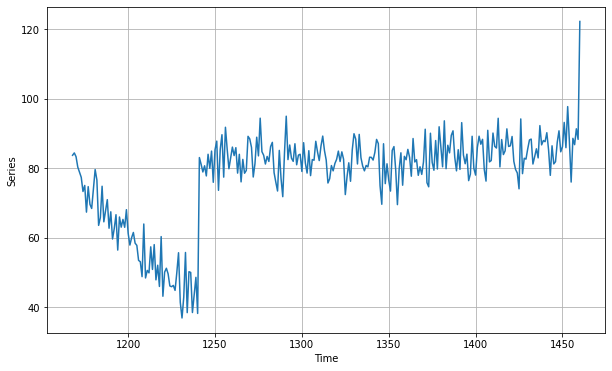

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

ab chalein suru karte hai : FORECASTING

## Naive Forecast

In [0]:
naive_forecast = series[splitTime-1: -1]

In [28]:
naive_forecast.shape

(293,)

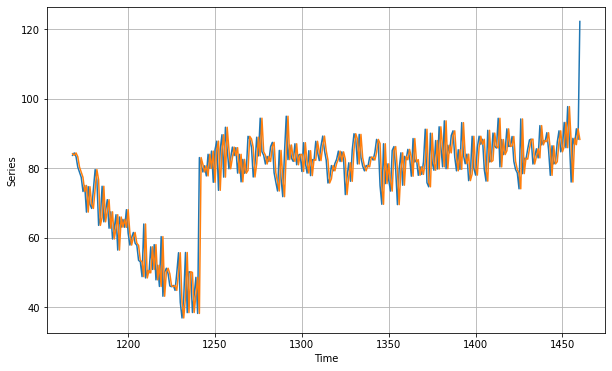

In [16]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show()

Let's zoom in into the figure.

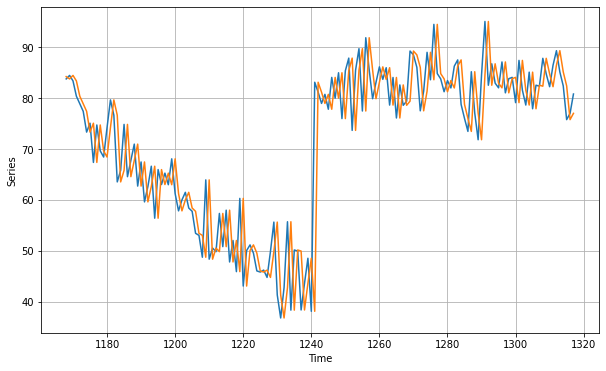

In [17]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)
plt.show()

Naive forecast is lagging by 1 time step.  
Let's compute the error between the forecasts and the predictions in the validation period.

In [18]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

58.036484
5.7661185


Okay. So this is our baseline error.Let's try to improve on this.

In [0]:
# try with moving average
def moving_average(series, windowSize):
  """
  Forecasts the mean of the last few values.  
  If window size=1, then this is equivalent to naive forecast.
  """
  forecast = []
  for time in range(len(series) - windowSize):
    forecast.append(series[time: time+windowSize].mean())

  return np.array(forecast)

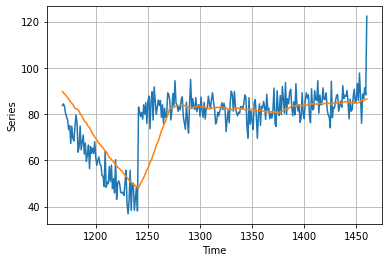

In [20]:
moving_avg = moving_average(series, 30)[splitTime - 30 : ]

plt.figure()
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.show()

In [21]:
# now check the error
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

93.94454
6.8531547


As we can obseve, its even worse than the naive forecast. Lets remove the moving average by using differencing. Subtract the seasonality value from time.

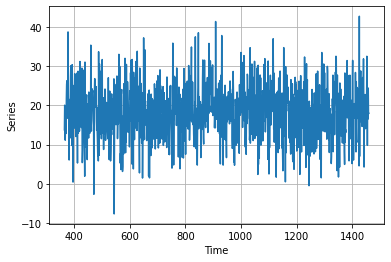

In [22]:
diffSeries = series[365: ] - series[:-365]
diffTime = time[365: ]

plt.figure()
plot_series(diffTime, diffSeries)
plt.show()

Yeah! The trend and seasonability is gone. Now we can apply moving average forecasting.

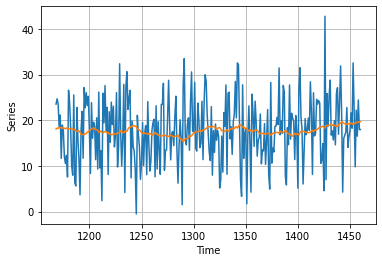

In [23]:
diffMovingAvg = moving_average(diffSeries, 50)[splitTime-365-50:]

plt.figure()
plot_series(time_valid, diffSeries[splitTime-365:])
plot_series(time_valid, diffMovingAvg)
plt.show()

Awesome! Let's add back the trend and seasonability.

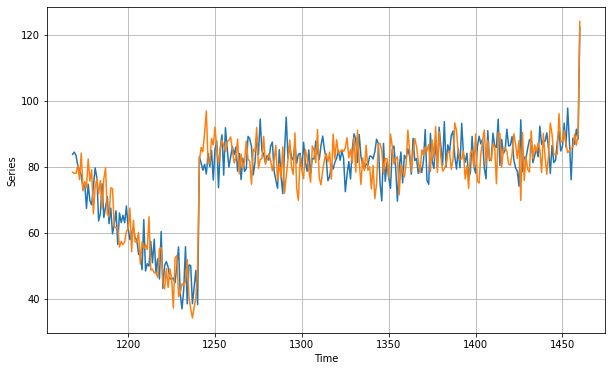

In [24]:
diffTotal = diffMovingAvg + series[splitTime-365 : -365]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diffTotal)
plt.show()

In [25]:
print(keras.metrics.mean_squared_error(x_valid, diffTotal).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diffTotal).numpy())

51.42362
5.738844


At least better than what we had in naive forecasting. Let's try to remove some noise.

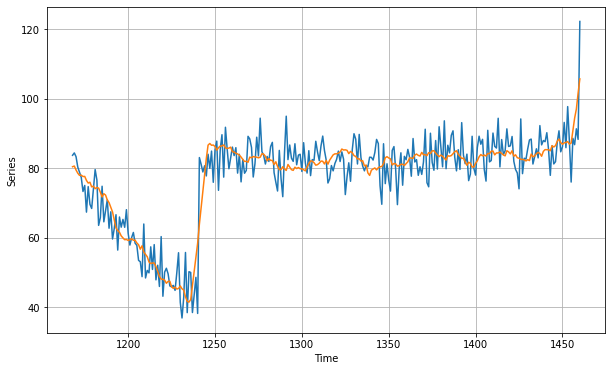

In [26]:
diffSmooth = diffMovingAvg + moving_average(series[splitTime-370:-360], 10)
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diffSmooth)
plt.show()

In [27]:
print(keras.metrics.mean_squared_error(x_valid, diffSmooth).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diffSmooth).numpy())

31.135775
4.415515


Boom! Much Better!